In [24]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.fftpack import dct
from scipy import signal as sig

In [25]:
def read_audio():
    path = 'audio/'
    sample_rate, signal = scipy.io.wavfile.read(path + 'english.wav')
    signal = signal[0:int(4 * sample_rate)]  # Keep the first 4 seconds
    plot_wav(sample_rate, signal, 'Signal in the Time Domain')
    T = signal.shape[0] / float(sample_rate)
    return sample_rate,signal,T

def plot_wav(sample_rate, signal, title=None):
    
    time = np.arange(len(signal))/float(sample_rate)
    
    plt.figure(figsize=(30, 4))
    plt.title(title)
    plt.fill_between(time, signal, color='b') 
    plt.xlim(time[0], time[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.savefig('plot.png', dpi=100)
    plt.grid(True)
    plt.show()
    
def plot_window(frame_length):
    
    n = np.arange(frame_length)
    h = 0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length-1))
    plt.figure(figsize=(6, 5))
    plt.plot(h, label='Hamming')
    plt.ylabel('Amplitude', fontsize=16)
    plt.xlabel('Samples', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.savefig('hamming_window.jpg', bbox_inches='tight', dpi=200)
    plt.show()
    
def plot_fbank(fbank, sample_rate, low_freq):
    
    plt.figure(figsize=(11, 2.5))
    plt.title('Filter bank on a Mel-Scale')
    plt.plot(np.linspace(low_freq, (sample_rate / 2), 257), fbank.T)
    plt.ylabel('Amplitude', fontsize=16)
    plt.xlabel('Frequency', fontsize=16)
    plt.grid(True)
    plt.savefig('mel_filters.jpg', bbox_inches='tight', dpi=200)
    plt.show()
    
def plot_spectrogram(filter_banks,time):
    
    plt.imshow(np.flipud(filter_banks.T), cmap=cm.jet, aspect=0.2, extent=[0,time,0,4])
    plt.title('Spectrogram of the Signal')
    plt.ylabel('Frequency (kHz)', fontsize=16)
    plt.xlabel('Time (s)', fontsize=16)
    plt.savefig('filter_banks_raw.jpg', bbox_inches='tight', dpi=200)
    plt.show()
    
def plot_mfcc(num_ceps, mfcc,time):
    
    plt.imshow(np.flipud(mfcc.T), cmap=cm.jet, aspect=0.08, extent=[0,time,1,num_ceps])
    plt.title('MFCCs')
    plt.ylabel('MFCC Coefficients', fontsize=16)
    plt.xlabel('Time (s)', fontsize=16)
    plt.savefig('mfcc_raw.jpg', bbox_inches='tight', dpi=200)
    plt.show

### Funcoes de utilidade

In [26]:
def feq2Mel(hz):
    return 2595 * np.log10(1 + (sample_rate / 2) / 700)
def Mel2feq(mel):
    return 700 * (10**(mel_points / 2595) - 1)

### Lendo Audio

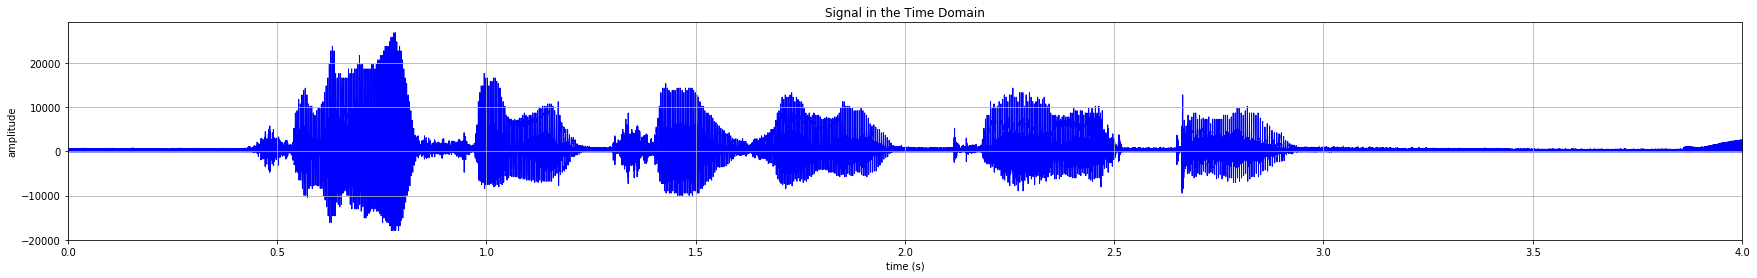

In [27]:
sample_rate, signal, time = read_audio()

### Aplicando Pré-Ênfase

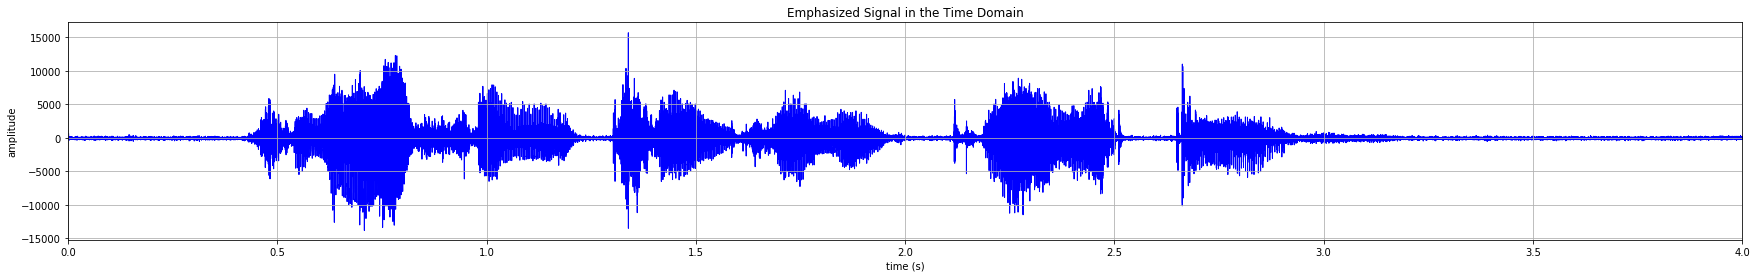

In [28]:
def linear_filter(alpha, t):
    return np.append(signal[0], signal[t:] - alpha * signal[:-t])
pre_emphasis = 0.97
emphasized_signal = linear_filter(pre_emphasis, 1)
plot_wav(sample_rate, emphasized_signal,'Emphasized Signal in the Time Domain')

### Separando em frames

In [29]:
frame_size_t = 0.025 # frame de 25 ms
frame_stride_t = 0.010 # 10 ms de deslocamento -> 15 ms de overlap
def split_frames(signal,size_t,stride_t):
    # convertendo em 'espaço' de sample
    frame_size = int(round(frame_size_t * sample_rate))
    frame_stride = int(round(frame_stride_t * sample_rate))  

    signal_length = len(emphasized_signal)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_size)) / frame_stride)) 

    # preenchendo com zeros para garantir que todos os frames tenham a mesma quantidade de samples

    # calculando o tamanho que deveria ter
    pad_signal_length = frame_size + num_frames * frame_stride
    z = np.zeros((pad_signal_length - signal_length))
    # faz padding 
    psignal = np.append(signal, z) 
    # acha os indices dos frames
    indices = np.tile(np.arange(0, frame_size), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_stride, frame_stride), (frame_size, 1)).T
    # usa os frames para encontrar os indices
    frames = psignal[indices.astype(np.int32, copy=False)]
    return signal, frames, frame_size

signal,frames,frame_length = split_frames(emphasized_signal,frame_size_t,frame_stride_t)

### Window

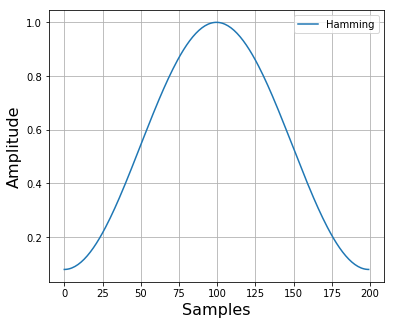

In [30]:
frames *= np.hamming(frame_length)
plot_window(frame_length)

### Power Spectrum

In [31]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2)) 

### Aplicando os filter banks aos power spectra

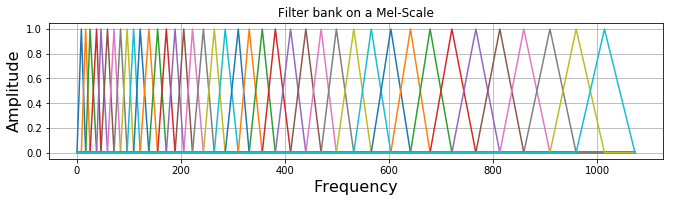

In [32]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = feq2Mel(sample_rate)

# criando pontos uniformemente espacados em espaco de mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

hz_points = Mel2feq(mel_points)

bins = np.floor((NFFT + 1) * hz_points / sample_rate)

# Separando em bancos de filtros e agregando
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bins[m - 1])   
    f_m = int(bins[m])             
    f_m_plus = int(bins[m + 1])    

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])

plot_fbank(fbank, high_freq_mel, low_freq_mel)

In [33]:
# Pegando o logaritmo dos filter banks (convertendo para dB)
filter_banks = np.dot(pow_frames, fbank.T)
# substitui 0 por epsilon (infinitadecimal) 
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)

In [34]:
# Pega o dct dos bancos
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')
# Fica apenas com 2 a 13
mfcc = mfcc[:, 1 : 13]

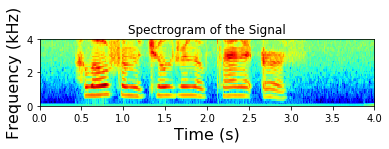

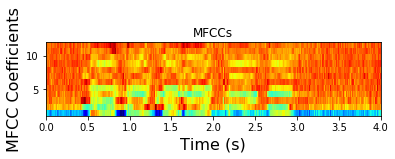

In [35]:
plot_spectrogram(filter_banks,time)
np.shape(mfcc)
fig, ax = plt.subplots()
plot_mfcc(12, mfcc,time)

In [36]:
# Faz o lifting
cep_lifter = 22
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

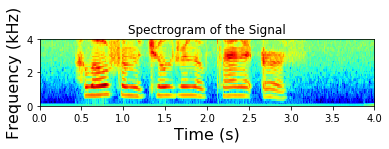

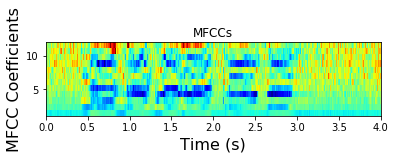

In [37]:
plot_spectrogram(filter_banks,time)
np.shape(mfcc)
fig, ax = plt.subplots()
plot_mfcc(12, mfcc,time)

### Existe a recomendacao de normalizar pela media para reduzir ruido. Efetivamente funciona.

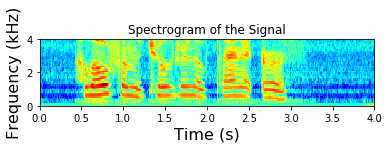

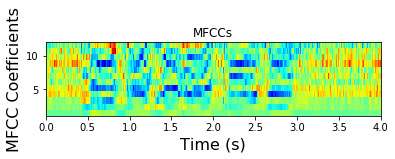

In [38]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
plot_spectrogram(filter_banks,time)
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
np.shape(mfcc)
fig, ax = plt.subplots()
plot_mfcc(12, mfcc,time)

In [39]:
### utilizei (alem do enunciado e do link ao fim do mesmo) o seguinte tutorial como base: 
# http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
